# Informacion por utilizar

In [108]:
#importamos las herramientas necesarias
import pynbody
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy import optimize
from astropy import units as unit
import sys
from matplotlib.animation import FuncAnimation

In [109]:
#importamos los datos
data_nuevo = '/media/danna01/Disk/SNAPSHOTS/Galaxias_Nuevas'
data_viejo = '/media/danna01/Disk/SNAPSHOTS/Galaxias_Viejas'
#datadir = '/media/juan/Pesquisa/Simulations_Chris_2021'

In [20]:
#A continuacion se lista la informacion importante para este notebook

# Masa Total de las componentes
# No. de partículas de cada componente
# El scale-length del disco de gas
# El scale-length del disco estelar
# La historia de formación de estrellas

In [118]:
#Estos son los diccionarios que definen los limites que seran utilizados para los plots de las galaxias para los
#calculos de densidad superficial radial para estrellas y para gases y para el calculo de la curva de rotacion
dicti = {}

galaxies = ['G0', 'G1', 'G2', 'G3']
#limites para graficar los plots
limites_densidad = {'G0':(0,20), 'G1':(0,25), 'G2':(0,20), 'G3':(0,55)}
#limites para calcular la h para el plot de estrellas y el de gas
limites_star = {'G0':(2,6),'G1':(5,10),'G2':(5,10),'G3':(15,20)}
limites_gas = {'G0':(2,6),'G1':(10,14),'G2':(13,16),'G3':(28,32)}
#limites en el eje y para los plots de gas, estrellas y para la curva de rotacion
limites_ejey_gas = {'G0':(-10, -2),'G1':(-6,-2),'G2':(-6,-2),'G3':(-6,-2)}
limites_ejey_star = {'G0':(-10, -2),'G1':(-10,0),'G2':(-6,0),'G3':(-10,0)}
limites_ejey_vel = {'G0':(-50, 120),'G1':(0,120),'G2':(0,150),'G3':(0,200)}

# Funciones

In [110]:
# En esta celda, vamos a calcular los puntos intermedios de los radios de los anillos a partir de los cuales 
# vamos a hacer los calculos. En equivalencia con las barras de los histogramas, estariamos hallando el punto
# medio de cada una de estas barras.

# Radial surface density of the disk
def density(pos,mass,n,limits):
    r       = np.sqrt((pos[:,:2]**2).sum(axis=1)) # Azymutal radius 
    histo   = np.histogram(r,n,range=limits)
    #plt.hist(r,n,range=limits)
    bins     = (histo[1][:-1]+histo[1][1:])/2
    bn_mass = np.zeros(n)
    # Aca sacamos la sumatoria de la masa que esta concentrada en cada una de las barras del histograma.
    for i in range(n):
            bn_mass[i]      = mass[(r >= histo[1][i])*(histo[1][i+1] > r)].sum()
    dens    = bn_mass/(np.pi)/((histo[1][1:])**2-(histo[1][:-1])**2)
    return histo,bins,dens

In [111]:
# esta celda es necesaria para calcular el error cuadrado mínimo para hallar la linea recta que se ajuste
# mejor a los datos obtenidos para la densidad superficial
def fit_exponential(x,y,limits):
    # Con la siguiente linea nos aseguramos de que los datos que tomemos para X esten en el intervalo que
    # definimos anteriormente, la multiplicacion es porque se considera que si ambos son verdaderos dara 1 y
    # seran considerados y si da cero, seran omitidos (en caso de que no cumpla con ambas condiciones)
    mask = (x >= limits[0])*(x <= limits[1])
    x = x[mask]
    y = y[mask]
    y = np.log10(y)
    # initial guess (punto inicial aproximado necesario para que la funcion de minimo cuadrado pueda funcionar)
    m_0 = (y[-1] - y[0])/(x[-1] - x[0])
    b_0 = y[0] - m_0*x[0]
    # Aca definimos la funcion de error y aplicamos el minimo cuadrado para hallar la funcion que mejor se acomode
    errfun  = lambda p: np.ravel(p[0]*x[:]+p[1]-y[:])
    fitparam = optimize.leastsq(errfun,[m_0,b_0],full_output=1)[0]
    m = fitparam[0]
    b = fitparam[1]
    return m,b

In [112]:
# esta celda simplemente funciona para definir todos los parametros de las graficas que son generadas para cada 
# snapshot y pues para cada tipo de dato (estrella, gas, etc.)
# Note que las funciones son de caracter exponencial y logaritmico.

def plot_exponential(bins,dens,m,b,filename):
    R = (-1./m)*np.log10(np.e)
    fig = plt.figure(figsize=(10, 7))
# importante: el calculo del valor de 'h'
# Para calcular el valor de h se consideran limites diferenciamos que permitan un calculo en regiones de la grafica
# mas lineales, para un mejor arreglo
    plt.plot(bins, np.log10(dens), 'r.', label = 'h = {a:3.2f}'.format(a = R))
    plt.plot(bins,m*bins+b,'-k')
    plt.legend(fontsize = 20, loc=0)
    plt.title('Perfil de densidad superficial de estrellas', fontsize = 18)
    plt.xlabel('Radio [Kpc]', fontsize = 20)
    plt.ylabel(r'$\rho$ [$1x10^{10}$ Msol/$kpc^{2}$]', fontsize = 20)
    plt.grid()
    plt.savefig(filename)
    plt.clf()
    plt.close()

In [113]:
# Radio azimutal 
# para ello, utilizamos los datos de la posicion tanto en x como en y
def RGas(data):
    Rg = np.sqrt(data.gas['pos'][:,0]**2 + data.gas['pos'][:,1]**2)
    return Rg

In [114]:
# Velocidad tangencial
def Vcartesian2polar(pos,vel):
    Vtan    = np.zeros(pos.shape[0])
    Vrad    = np.zeros(pos.shape[0])
    norm    = np.sqrt(pos[:,0]**2+pos[:,1]**2)
    Vtan    = (vel[:,1]*pos[:,0]-vel[:,0]*pos[:,1])/norm
    Vrad    = (vel[:,0]*pos[:,0]+vel[:,1]*pos[:,1])/norm
    return Vtan,Vrad

In [115]:
# Dada una secuencia de puntos, que serán los extremos
# de las casillas de los bins de un histograma, saca los puntos medios
# de cada casilla como referencia
def radios(points):
    radii     = (points[:-1]+points[1:])/2
    return radii 

In [116]:
# Función que retorna la curva de rotación para las partículas
# de gas en una galaxia tipo disco en rotación. 
# Lo hace con bins circulares, tomando en cada bin la media de
# las velocidades tangenciales, pero ponderada por la masa de cada partícula
# Es decir, en cada bin define:
# <V_cir> = Sum(V_tan * mass) / Sum(mass)
# Bajo condiciones normales, cada particula valdria lo mismo, pero en este caso, el valor de cada
# particula dependera de su masa.

def RotCurvGas(data,points):
    a = np.histogram(RGas(data), bins=points,  weights= Vcartesian2polar(data.gas["pos"],data.gas["vel"])[0]*data.gas['mass'])
    b = np.histogram(RGas(data), bins=points,  weights= data.gas['mass'])
    Vel = (a[0]/b[0])
    return a[1][0:len(points)-1],Vel

In [117]:
# Calcula la curva de rotacion, la grafica y almacena la figura
# Returna el valor máximo de la curva de rotación
def plot_rot_curve(gal,data,filename):
    r_bins = np.arange(limites_densidad['G0'][0],limites_densidad['G0'][1],0.5)
    Vel = RotCurvGas(data,r_bins)[1]
    r = radios(r_bins)
    plt.plot(r,Vel)
    
    fig = plt.figure(figsize=(10, 7))
    plt.plot(r,Vel)
    plt.title('Curva de rotación del gas', fontsize = 18)
    plt.xlabel('Radio [Kpc]', fontsize = 20)
    plt.ylabel(r'$V_{circular}$ [km / s]', fontsize = 20)
    plt.grid()
    plt.savefig(filename)
    plt.clf()
    plt.close()
    
    return np.nanmax(Vel)

# Graficas y Animaciones

In [83]:
#Con esta funcion se realizan normalmente los plots para cada una de las galaxias, sin embargo, realizar un plot 
#por cada snapshot para cada galaxia es ineficiente y por eso se realizan animaciones mas adelante
#SIn embargo, aca se generan las ecuaciones basicas para generar los plots

#Aca definimos los plots que vamos a calcular
minsnap = 1
maxsnap = 601
stepsnap = 1

#definimos la fuente de los datos
for gal in galaxies:
    for snap in np.arange(minsnap,maxsnap,stepsnap): 
        snap = str(snap).zfill(3)
        data = pynbody.load(data_nuevo+'/'+gal+'/snapshot_'+snap+'.hdf5')
        
        #aplicamos la formula de V_max definida previamente para generar el plot y la forma en que sera acumulada
        V_max = plot_rot_curve(gal,data,filename='plots/'+gal+'_rotcurve_'+snap+'.jpg')
        
        N_star = data.star['mass'].size
        
        #hacemos lo mismo para el plot de densidad superficial radial del gas
        histo,bins,dens = density(data.gas['pos'],data.gas['mass'],n=20,limits=limites_densidad[gal])
        m,b = fit_exponential(bins,dens,limits=limites_gas[gal])
        plot_exponential(bins,dens,m,b,filename='plots/'+gal+'_gas_'+snap+'.jpg')
       
        #hacemos lo mismo para el plot de densidad superficial radial de las estrellas
        histo,bins,dens = density(data.star['pos'],data.star['mass'],n=20,limits=limites_densidad[gal])
        m,b = fit_exponential(bins,dens,limits=limites_star[gal])
        plot_exponential(bins,dens,m,b,filename='plots/'+gal+'_star_'+snap+'.jpg')  

/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No un

/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No un

In [ ]:
#FUNCION MODIFICADA [MODELO PARA TODAS LAS ANIMACIONES]

#gal = 'G0'    
   
#plt.style.use('seaborn-pastel')

#fig = plt.figure()
#ax = plt.axes(xlim=(0, 20), ylim=(-10, -2))
#puntos, = ax.plot([], [],'r.')
#ajuste, = ax.plot([], [],'--b')


#plt.title('Perfil de densidad superficial de gas', fontsize = 18)
#plt.xlabel('Radio [Kpc]', fontsize = 20)
#plt.ylabel(r'$\rho$ [$1x10^{10}$ Msol/$kpc^{2}$]', fontsize = 20)
#plt.grid()

#def init():
    #puntos.set_data([], [])
    #return puntos, ajuste,

#def animate(i):
    #snap = str(i).zfill(3)
    #data = pynbody.load(data_nuevo+'/'+gal+'/snapshot_'+snap+'.hdf5')
    #histo,bins,dens = density(data.gas['pos'],data.gas['mass'],n=20,limits=limites_densidad[gal])
    #m,b = fit_exponential(bins,dens,limits=limites[gal])
    #R = (-1./m)*np.log10(np.e)
    #x = bins
    #y = np.log10(dens)
    #y2 = m*bins+b
    #puntos.set_data(x, y)
    #ajuste.set_data(x, y2)
    #puntos.set_label('h = {a:3.2f}'.format(a = R))
    #plt.legend(fontsize = 20, loc=0)
    #return puntos,  ajuste,

#anim = FuncAnimation(fig, animate, init_func=init,
                               #frames=10, interval=40, blit=True)


#anim.save('sine_wave_gas_'+gal+'.gif', writer='imagemagick')

/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
<ipython-input-119-b66e0f496aef>:26: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(dens)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarn

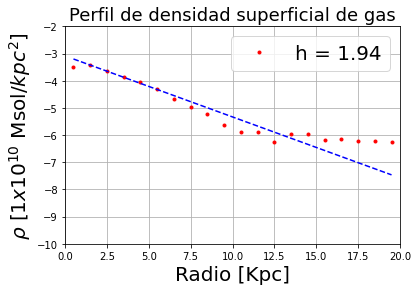

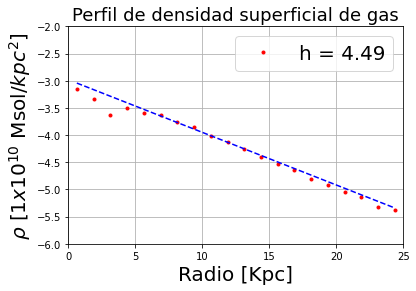

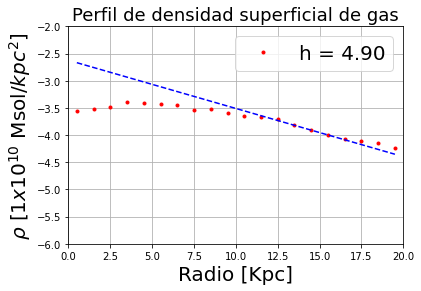

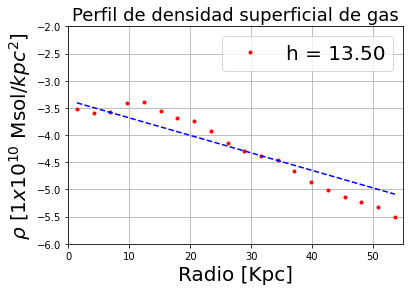

In [119]:
#Con esta celda generamos la animacion de los plots en este caso para la densidad superficial radial para el
#caso del gas

for gal in galaxies:
    plt.style.use('seaborn-pastel')
    #los limites fueron definidos por prueba y error tanto para x como para y y se pueden observar al principio
    #del documento
    fig = plt.figure()
    ax = plt.axes(xlim= limites_densidad[gal] , ylim= limites_ejey_gas[gal])
    #la funcion puntos hace referencia a los datos originales y la funcion ajuste a la linea recta generada con el
    #menor error posible y que mejor se deberia ajustar a los datos
    puntos, = ax.plot([], [],'r.')
    ajuste, = ax.plot([], [],'--b')

    #aca se definen las caracteristicas generales del plot
    plt.title('Perfil de densidad superficial de gas', fontsize = 18)
    plt.xlabel('Radio [Kpc]', fontsize = 20)
    plt.ylabel(r'$\rho$ [$1x10^{10}$ Msol/$kpc^{2}$]', fontsize = 20)
    plt.grid()

    #aca se genera una funcion inicial vacia
    def init():
        puntos.set_data([], [])
        return puntos, ajuste,

    #aca si generamos la animacion propiamente dicha en donde i hara referencia al numero del snapshot 
    #y donde las funciones de los plots han sido adaptadas para la animacion.
    def animate(i):
        snap = str(i).zfill(3)
        data = pynbody.load(data_nuevo+'/'+gal+'/snapshot_'+snap+'.hdf5')
        histo,bins,dens = density(data.gas['pos'],data.gas['mass'],n=20,limits=limites_densidad[gal])
        m,b = fit_exponential(bins,dens,limits=limites_gas[gal])
        R = (-1./m)*np.log10(np.e)
        x = bins
        y = np.log10(dens)
        y2 = m*bins+b
        puntos.set_data(x, y)
        ajuste.set_data(x, y2)
        puntos.set_label('h = {a:3.2f}'.format(a = R))
        plt.legend(fontsize = 20, loc=0)
        return line,  ajuste,

    anim = FuncAnimation(fig, animate, init_func=init,
                               frames=600, interval=60, blit=True)


    anim.save('perfil_densidad_gas_'+gal+'.gif', writer='imagemagick')
#El proceso se repitio exactamente igual con los demas plots para generar las otras animaciones.

/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
<ipython-input-120-36f202b18d14>:28: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(dens)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
<ipython-input-120-36f202b18d14>:28: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(dens)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethd

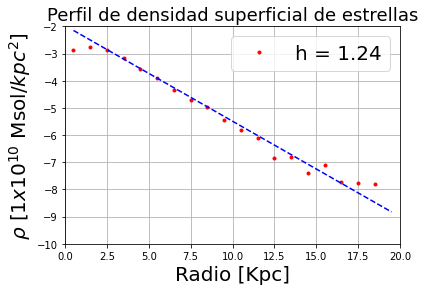

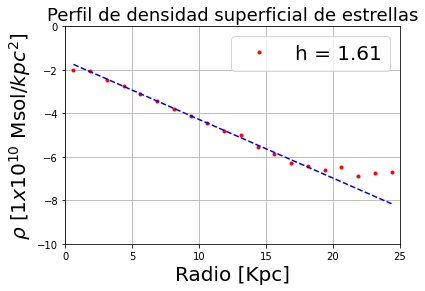

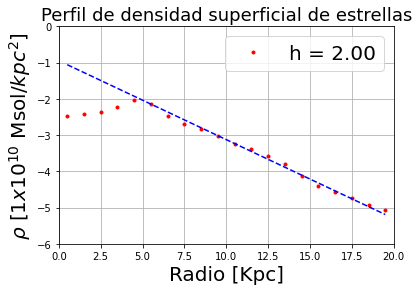

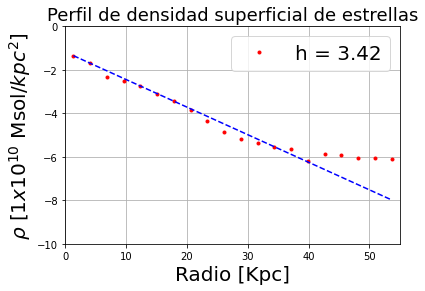

In [120]:
for gal in galaxies:

    plt.style.use('seaborn-pastel')

    fig = plt.figure()
    ax = plt.axes(xlim= limites_densidad[gal], ylim=limites_ejey_star[gal])
    puntos, = ax.plot([], [],'r.')

    ajuste, = ax.plot([], [],'--b')


    plt.title('Perfil de densidad superficial de estrellas', fontsize = 18)
    plt.xlabel('Radio [Kpc]', fontsize = 20)
    plt.ylabel(r'$\rho$ [$1x10^{10}$ Msol/$kpc^{2}$]', fontsize = 20)
    plt.grid()

    def init():
        puntos.set_data([], [])
        return puntos, ajuste,

    def animate(i):
        snap = str(i).zfill(3)
        data = pynbody.load(data_nuevo+'/'+gal+'/snapshot_'+snap+'.hdf5')
        histo,bins,dens = density(data.star['pos'],data.star['mass'],n=20,limits=limites_densidad[gal])
        m,b = fit_exponential(bins,dens,limits=limites_star[gal])
        R = (-1./m)*np.log10(np.e)
        x = bins
        y = np.log10(dens)
        y2 = m*bins+b
        puntos.set_data(x, y)
        ajuste.set_data(x, y2)
        puntos.set_label('h = {a:3.2f}'.format(a = R))
        plt.legend(fontsize = 20, loc=0)
        return puntos,  ajuste,

    anim = FuncAnimation(fig, animate, init_func=init,
                               frames=600, interval=60, blit=True)


    anim.save('perfil_densidad_star_'+gal+'.gif', writer='imagemagick')

/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
<ipython-input-116-31cb759b3ec3>:13: RuntimeWarning: invalid value encountered in true_divide
  Vel = (a[0]/b[0])
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:572: RuntimeWarning: No unit information found: using gadget-units.
  warnings.warn(
/home/danna01/.local/lib/python3.8/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", Runtime

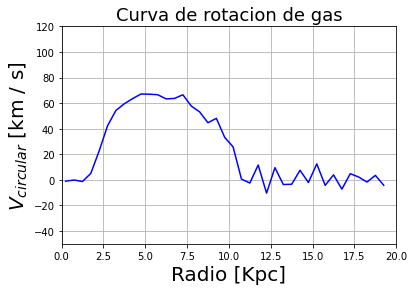

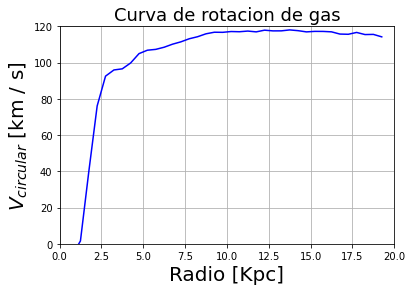

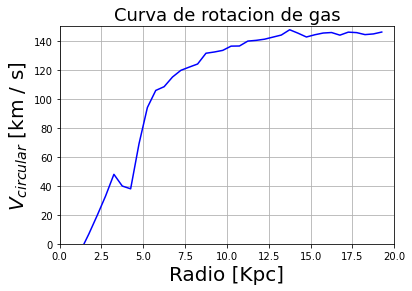

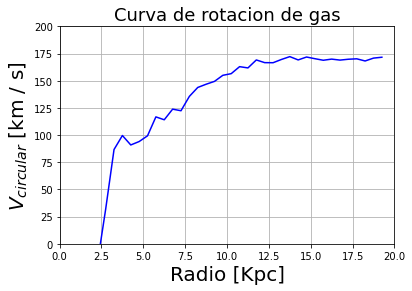

In [121]:
for gal in galaxies:

    plt.style.use('seaborn-pastel')

    fig = plt.figure()
    ax = plt.axes(xlim=(0, 20), ylim= limites_ejey_vel[gal])
    line, = ax.plot([], [],'-b')

    plt.title('Curva de rotacion de gas', fontsize = 18)
    plt.xlabel('Radio [Kpc]', fontsize = 20)
    plt.ylabel(r'$V_{circular}$ [km / s]', fontsize = 20)
    plt.grid()

    def init():
        line.set_data([], [])
        return line, 

    def animate(i):
        snap = str(i).zfill(3)
        data = pynbody.load(data_nuevo+'/'+gal+'/snapshot_'+snap+'.hdf5')
        r_bins = np.arange(limites_densidad['G0'][0],limites_densidad['G0'][1],0.5)
        r = radios(r_bins)
        Vel = RotCurvGas(data,r_bins)[1]
        x = r
        y = Vel
        line.set_data(x, y)
        return line, 

    anim = FuncAnimation(fig, animate, init_func=init,
                               frames=600, interval=60, blit=True)


    anim.save('curva_rotacion_'+gal+'.gif', writer='imagemagick')